In [1882]:
#import libs
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt;

### Overall

In [1883]:
# see the data
train = pd.read_csv('../../data/house-prices/train.csv')
test = pd.read_csv('../../data/house-prices/test.csv');

#### outlier

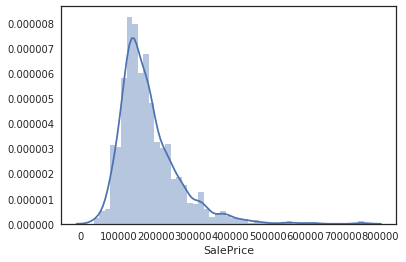

In [1884]:
sns.distplot(train['SalePrice'])

In [1885]:
# outlier first
# pos = np.where(train['SalePrice'] < 40000)
# train.drop(labels=pos[0],axis=0,inplace=True)
# train.drop(labels=[825,88],axis=0,inplace=True)
train_len = len(train)
test_len = len(test)
print(train_len)
print(test_len)

1460
1459


In [1886]:
ids = test['Id']

In [1887]:
if 'SalePrice' in train:
    y = train['SalePrice']

if 'Id' in test:
    ids = test.pop('Id')
    train.pop('Id')

In [1888]:
dataset = pd.concat([train, test],axis=0,ignore_index=True)
dataset.reset_index(drop=True)
print(dataset.shape)
dataset.isnull().sum()

(2919, 80)


1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
Alley            2721
BedroomAbvGr        0
BldgType            0
BsmtCond           82
BsmtExposure       82
BsmtFinSF1          1
BsmtFinSF2          1
BsmtFinType1       79
BsmtFinType2       80
BsmtFullBath        2
BsmtHalfBath        2
BsmtQual           81
BsmtUnfSF           1
CentralAir          0
Condition1          0
Condition2          0
Electrical          1
EnclosedPorch       0
ExterCond           0
ExterQual           0
Exterior1st         1
Exterior2nd         1
Fence            2348
FireplaceQu      1420
Fireplaces          0
Foundation          0
FullBath            0
                 ... 
LotShape            0
LowQualFinSF        0
MSSubClass          0
MSZoning            4
MasVnrArea         23
MasVnrType         24
MiscFeature      2814
MiscVal             0
MoSold              0
Neighborhood        0
OpenPorchSF         0
OverallCond         0
OverallQual         0
PavedDrive          0
PoolArea  

In [1889]:
dataset = dataset.reindex(index=range(dataset.shape[0]))

### Data preprocessing

#### Alley
fill nan with random Grvl and Pave

In [1890]:
dataset['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [1891]:
null_alley = dataset.loc[dataset['Alley'].isnull(),'Alley']
null_num = len(null_alley)
L = [ 'Grvl', 'Pave']
random_list = np.random.random_integers(1,null_num,null_num)
random_val = [ L[ x % len(L)] for x in random_list]
dataset.loc[dataset['Alley'].isnull(),'Alley'] = random_val

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 2721 + 1) instead
  after removing the cwd from sys.path.


In [1892]:
dataset['Alley'].unique()

array(['Pave', 'Grvl'], dtype=object)

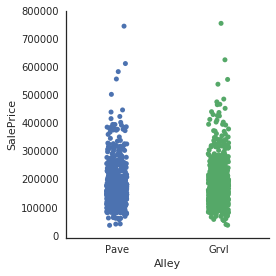

In [1893]:
sns.factorplot(x='Alley',y='SalePrice',data=dataset,kind='strip',jitter=True)

#### Bsmt features

I found Cannot treat null basement feature one bay one , let's try to consider them all together:
```
BsmtCond           82
BsmtExposure       82
BsmtFinSF1          1
BsmtFinSF2          1
BsmtFinType1       79
BsmtFinType2       80
BsmtFullBath        2
BsmtHalfBath        2
BsmtQual           81
BsmtUnfSF           1
```

In [1894]:
Bsmt_fl = ['BsmtCond','BsmtExposure','BsmtFinSF1','BsmtFinSF2','BsmtFinType1','BsmtFinType2','BsmtFullBath','BsmtHalfBath','BsmtQual','BsmtUnfSF']

Very large proboblity theat `Bsmt` null features at same time. let's see

Note that :
`&`  compares Series different 

In [1895]:
pd.Series([ True, False]) & pd.Series ([False , True] )

0    False
1    False
dtype: bool

In [1896]:
all_null_basement = dataset['BsmtCond'].isnull() &\
dataset['BsmtExposure'].isnull()  &\
dataset['BsmtFinType1'].isnull()  &\
dataset['BsmtFinType2'].isnull()  &\
dataset['BsmtQual'].isnull() &\
(dataset['BsmtFinSF1'] ==0.0)  &\
(dataset['BsmtFinSF2'] ==0.0) &\
(dataset['BsmtUnfSF'] == 0) &\
(dataset['BsmtFullBath'] == 0) &\
(dataset['BsmtHalfBath'] == 0)

print('all null and o sum is' ,sum (all_null_basement.where(all_null_basement==True,0) ) )

all null and o sum is 77


Let's compare the price of full-null basement and norm ones, and create a new feature called `FullnullBsmt`,see it in train set

In [1897]:
all_notnull_basement = (all_null_basement == False)

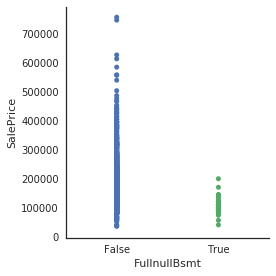

In [1898]:
dataset['FullnullBsmt']=all_null_basement
sns.factorplot(x='FullnullBsmt',y='SalePrice',data=dataset,kind='strip')

Obviously an important feature for price. How to feel those NaN? 

Analyse price lower than 20000, find the mostly possiable Catirgorial Bsmt features

In [1899]:
Bsmt_catigorail_fl = ['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual']

In [1900]:
conds =  (train['SalePrice'] < 200000) & all_notnull_basement[:train_len]
childset = train.loc[conds,Bsmt_catigorail_fl]
print('describe dtype: ',type(childset.describe()))
childset.describe()

describe dtype:  <class 'pandas.core.frame.DataFrame'>


,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
count,988,987,988,988,988
unique,4,4,6,6,4
top,TA,No,Unf,Unf,TA
freq,909,741,317,859,601


Let's use the top one to fill those NaN then fill remaining sepcial casies.

In [1901]:
for x in Bsmt_catigorail_fl :
    dataset.loc[all_null_basement,x] =childset.describe().loc['top'][x] 

In [1902]:
dataset.loc[dataset['BsmtCond'].isnull() , Bsmt_fl]

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF
2040,NaN,Mn,1044.0,382.0,GLQ,Rec,1.0,0.0,Gd,0.0
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2185,NaN,No,1033.0,0.0,BLQ,Unf,0.0,1.0,TA,94.0
2188,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
2524,NaN,Av,755.0,0.0,ALQ,Unf,0.0,0.0,TA,240.0


Let's see it one by one 
```
580 good ;
660,728 just as top
725 middle 
1064 middle 
```
```
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

```

In [1903]:
dataset.loc[2040,['BsmtCond']]='Ex'
dataset.loc[[2120,2185],['BsmtCond']]='TA'

In [1904]:
for x in Bsmt_catigorail_fl :
    dataset.loc[[2188,2524,2120],x] =childset.describe().loc['top'][x] 

In [1905]:
dataset[Bsmt_fl].isnull().sum()

BsmtCond        0
BsmtExposure    3
BsmtFinSF1      1
BsmtFinSF2      1
BsmtFinType1    0
BsmtFinType2    1
BsmtFullBath    2
BsmtHalfBath    2
BsmtQual        2
BsmtUnfSF       1
dtype: int64

##### BsmtExposure
```
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

```

In [1906]:
dataset.loc[dataset['BsmtExposure'].isnull() ,Bsmt_fl]

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF
948,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,936.0
1487,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,1595.0
2348,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,725.0


In [1907]:
dataset.loc[[948,1487,2348],['BsmtExposure']]='Gd'

In [1908]:
dataset[Bsmt_catigorail_fl].isnull().sum()

BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    1
BsmtQual        2
dtype: int64

##### BsmtType2

In [1909]:
dataset.loc[dataset['BsmtFinType2'].isnull() ,Bsmt_fl]

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF
332,TA,No,1124.0,479.0,GLQ,NaN,1.0,0.0,Gd,1603.0


In [1910]:
dataset.loc[[332],['BsmtFinType2']]='GLQ'

#####  BsmtQual

In [1911]:
dataset.loc[dataset['BsmtQual'].isnull() ,Bsmt_fl]

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF
2217,Fa,No,0.0,0.0,Unf,Unf,0.0,0.0,NaN,173.0
2218,TA,No,0.0,0.0,Unf,Unf,0.0,0.0,NaN,356.0


In [1912]:
dataset.loc[[2217],['BsmtQual']]='Fa'
dataset.loc[[2218],['BsmtQual']]='TA'

In [1913]:
dataset[Bsmt_catigorail_fl].isnull().sum()

BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtQual        0
dtype: int64

In [1914]:
dataset[Bsmt_fl].isnull().sum()

BsmtCond        0
BsmtExposure    0
BsmtFinSF1      1
BsmtFinSF2      1
BsmtFinType1    0
BsmtFinType2    0
BsmtFullBath    2
BsmtHalfBath    2
BsmtQual        0
BsmtUnfSF       1
dtype: int64

#####  BsmtFinSF1 BsmtFinSF2  BsmtFullBath BsmtHalfBath  BsmtUnfSF
Go on with numerial Bsmt features

In [1915]:
dataset.loc[dataset['BsmtFinSF1'].isnull() ,Bsmt_fl]

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF
2120,TA,No,NaN,NaN,Unf,Unf,NaN,NaN,TA,NaN


In [1916]:
dataset.loc[dataset['BsmtFinSF1'].isnull() ,'BsmtFinSF1']=0
dataset.loc[dataset['BsmtFinSF2'].isnull() ,'BsmtFinSF2']=0
dataset.loc[dataset['BsmtFullBath'].isnull() ,'BsmtFullBath']=0
dataset.loc[dataset['BsmtHalfBath'].isnull() ,'BsmtHalfBath']=0
dataset.loc[dataset['BsmtUnfSF'].isnull() ,'BsmtUnfSF']=0

In [1917]:
dataset[Bsmt_fl].isnull().sum()

BsmtCond        0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtFinType1    0
BsmtFinType2    0
BsmtFullBath    0
BsmtHalfBath    0
BsmtQual        0
BsmtUnfSF       0
dtype: int64

#### Electrical

In [1918]:
dataset.loc[dataset['Electrical'].isnull(),'Electrical']='FuseA'

#### Exterior1st Exterior2nd
`VinylSd` mostly used.

In [1919]:
ex=dataset.loc[dataset['Exterior1st'].isnull()]

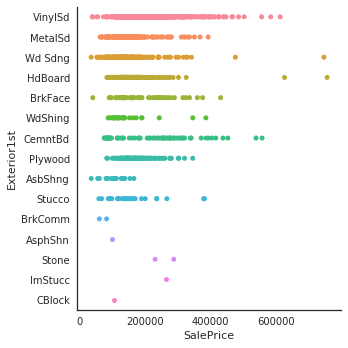

In [1920]:
sns.factorplot(y='Exterior1st',x='SalePrice',data=train,kind='strip',size=5,orient='h')

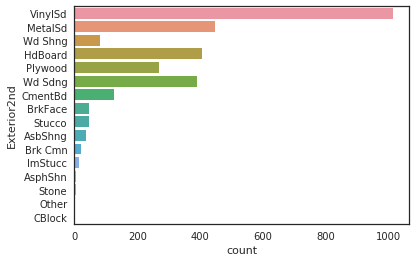

In [1921]:

sns.countplot(y='Exterior2nd',data=dataset,orient='h')

In [1922]:
dataset.loc[dataset['Exterior1st'].isnull(),'Exterior1st']='VinylSd'

In [1923]:
dataset.loc[dataset['Exterior2nd'].isnull(),'Exterior2nd']='VinylSd'

#### Fence

The better fence, the higher price

In [1924]:
dataset['Fence'].unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [1925]:
# train.loc[train['Fence'].isnull()]

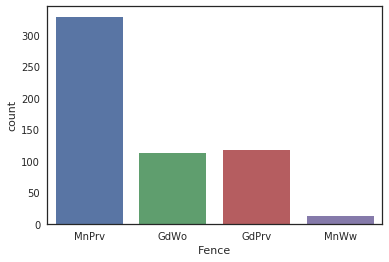

In [1926]:
sns.countplot(x='Fence',data=dataset)

Most of fences are MnPrv.

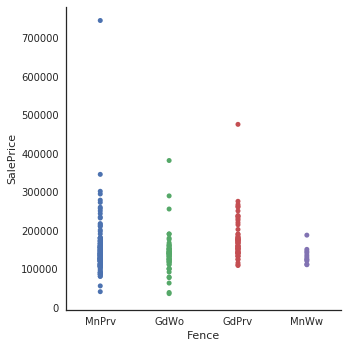

In [1927]:
sns.factorplot(x='Fence',y='SalePrice',data=train,kind='strip',size=5) 

if price > 16000 random initialzation strategies between MinPrv GdPrv and GdPrv

 if price <  16000 random between 
 
But from stip , some special point are there so we need care about them.

In [1928]:
dataset['Fence']=dataset['Fence'].astype('category')
dataset['Fence'].unique()

[NaN, MnPrv, GdWo, GdPrv, MnWw]
Categories (4, object): [MnPrv, GdWo, GdPrv, MnWw]

```
MnPrv-->2 ;
GdWo-->1;
GdPrv-->0;
MnWw--3
```



In [1929]:
# make cat numerical to apply factorplot
dataset['Fence_num']=dataset['Fence'].cat.codes
dataset['Fence_num'] =  dataset['Fence_num'].astype(int)

Let's try to find some features that releverant with `non-null Fence` to decide how in fill NaN.

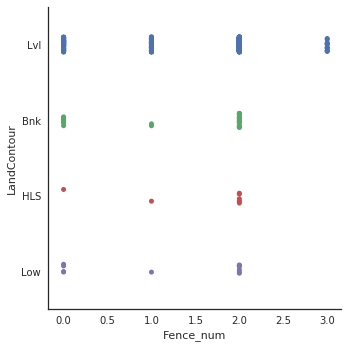

In [1930]:
sns.factorplot(y='LandContour',x='Fence_num',data=dataset.loc[dataset['Fence'].isnull()==False],kind='strip',jitter=True,size=5) 

It means LandContour='HLS' mostly has  Fence_num = 2

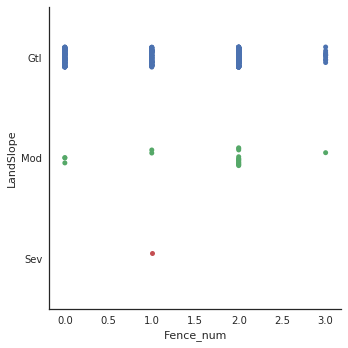

In [1931]:
sns.factorplot(y='LandSlope',x='Fence_num',data=dataset.loc[dataset['Fence'].isnull()==False],kind='strip',jitter=True,size=5) 

If LandSlope =`Sev` , only possible Fence_num  = 1 , if Mod and Gtl possibly Fence_num = [ 0 1 2 3 ]

if LotConfig == RH , fence_num only = 2

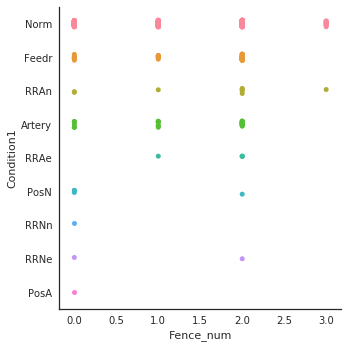

In [1932]:
#Condition1
sns.factorplot(y='Condition1',x='Fence_num',data=dataset.loc[dataset['Fence'].isnull()==False],kind='strip',jitter=True,size=5) 

if Condition1== RRNn RRne PosA, fence_num can not be 1 or 3

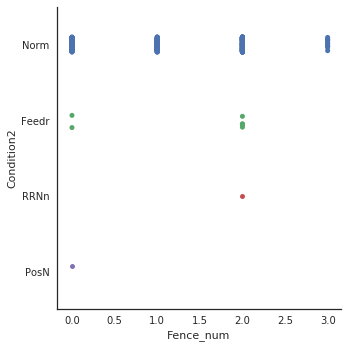

In [1933]:
#Condition2
sns.factorplot(y='Condition2',x='Fence_num',data=dataset.loc[dataset['Fence'].isnull()==False],kind='strip',jitter=True,size=5) 

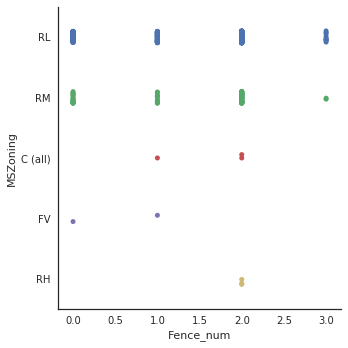

In [1934]:
#MSZoning
sns.factorplot(y='MSZoning',x='Fence_num',data=dataset.loc[dataset['Fence'].isnull()==False],kind='strip',jitter=True,size=5)

if MSZoning == `RH` , possible Fence_num = 2

if MSZoning == `C` , possible Fence_num = 1 and 2 

if MSZoning == `FV` , possible Fence_num = 0 and 1

##### Fill NaN by probablities


In [1935]:
dataset['Fence'].unique()

[NaN, MnPrv, GdWo, GdPrv, MnWw]
Categories (4, object): [MnPrv, GdWo, GdPrv, MnWw]

In [1936]:
fence_notnull_set = dataset.loc[dataset['Fence'].isnull()==False]
lens = len(fence_notnull_set['Fence'] )
print(lens)
probs= (fence_notnull_set['Fence'].value_counts() / lens ).tolist()
print(probs)

571
[0.5761821366024519, 0.20665499124343256, 0.19614711033274956, 0.021015761821366025]


In [1937]:
fence_t = dataset['Fence'].cat.categories.tolist()
fence_null_nums  = len(dataset.loc[dataset['Fence'].isnull()])
fence_null = np.random.choice(fence_t,fence_null_nums,p=probs)

dataset.loc[dataset['Fence'].isnull(),'Fence'] = fence_null

dataset['Fence'].unique()


[MnPrv, GdPrv, GdWo, MnWw]
Categories (4, object): [MnPrv, GdPrv, GdWo, MnWw]

##### Fine tuning Fence 

Summerize together:

```
MnPrv-->2 ;
GdWo-->1;
GdPrv-->0;
MnWw--3
```

It means LandContour=HLS mostly has  Fence_num = 2

if LotConfig == RH , fence_num only = 2

If LandSlope =`Sev` , only possible Fence_num  = 1

if Condition1== RRNn RRne PosA, fence_num can not be 1 or 3

if MSZoning == RH, possible Fence_num = 2

if MSZoning == r`C (all)` , possible Fence_num = 1 and 2

if MSZoning == `FV` , possible Fence_num = 0 and 1

In [1938]:
np.random.randint(10,1000,1)[0]

519

In [1939]:
dataset.loc[dataset['LandContour']=='HLS','Fence' ] ='MnPrv'
dataset.loc[dataset['LotConfig']=='RH','Fence' ] ='MnPrv'
dataset.loc[dataset['LandSlope']=='Sev','Fence' ] ='GdWo'
dataset.loc[ (dataset['Condition1']=='RRNn') |  (dataset['Condition1']=='PosA')  |  (dataset['Condition1']=='RRne') ,'Fence' ] ='GdPrv'
dataset.loc[ (dataset['Condition2']=='PosN') ,'Fence' ] ='GdPrv'
dataset.loc[ (dataset['MSZoning']=='RH') ,'Fence' ] ='GdPrv'

tmp = dataset.loc[dataset['MSZoning']==r'C (all)','Fence'] 
d = ['GdWo','MnPrv']
lens = len(tmp)
dataset.loc[dataset['MSZoning']==r'C (all)','Fence']  = [ d[ x % len(d)] for x in np.random.randint(10,1000,lens)]

tmp = dataset.loc[dataset['MSZoning']==r'FV','Fence'] 
d = ['GdWo','GdPrv']
lens = len(tmp)
dataset.loc[dataset['MSZoning']==r'FV','Fence']  = [ d[ x % len(d)] for x in np.random.randint(10,1000,lens)]



In [1940]:
dataset.drop(labels=['Fence_num'],axis=1,inplace=True)

#### FireplaceQu

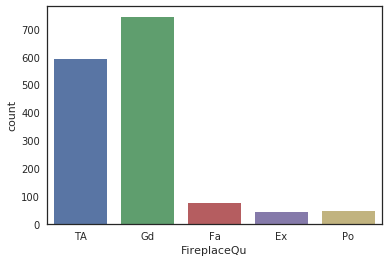

In [1941]:
sns.countplot(x='FireplaceQu',data=dataset)

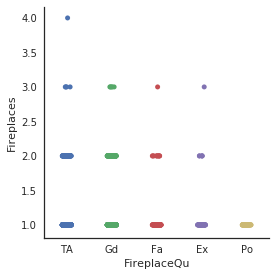

In [1942]:
sns.factorplot(x='FireplaceQu',y='Fireplaces',data=dataset,kind='strip',jitter=True)

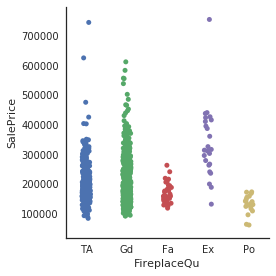

In [1943]:
sns.factorplot(x='FireplaceQu',y='SalePrice',data=dataset,kind='strip',jitter=True)

FireplaceQu Mostly in [Ta Gd]

if Fireplaces == 1  FireplaceQu != Po

In [1944]:
tmp = dataset.loc[dataset['FireplaceQu'].isnull()] 
d = ['TA','Gd'] 
# not include Po , thus fits condition :  if Fireplaces == 1  FireplaceQu != Po
lens = len(tmp)
dataset.loc[dataset['FireplaceQu'].isnull(),'FireplaceQu']  = [ d[ x % len(d)] for x in np.random.randint(10,1000,lens)]


#### MSZoning

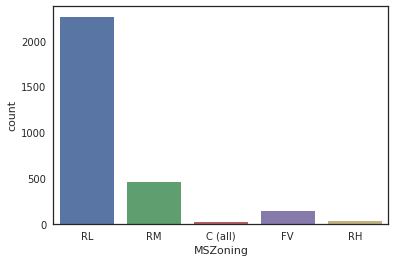

In [1945]:
sns.countplot(x='MSZoning',data=dataset)

In [1946]:
dataset.loc[dataset['MSZoning'].isnull() ,'MSZoning'] = 'RL';

#### MasVnrArea


In [1947]:
dataset.loc[dataset['MasVnrArea'].isnull() ,'MasVnrArea'] = dataset['MasVnrArea'].median()

#### MasVnrType

In [1948]:
dataset.loc[dataset['MasVnrType'].isnull()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,FullnullBsmt
234,860,1100,0,Pave,4,1Fam,TA,No,625.0,0.0,...,0,Pave,8,860.0,AllPub,288,2002,2002,2010,False
529,2515,0,0,Pave,4,1Fam,TA,No,1219.0,0.0,...,0,Pave,9,2035.0,AllPub,0,1957,1975,2007,False
650,822,843,0,Pave,3,1Fam,TA,No,0.0,0.0,...,0,Pave,7,813.0,AllPub,0,2007,2007,2008,False
936,1200,0,0,Grvl,2,1Fam,TA,No,833.0,0.0,...,0,Pave,5,1176.0,AllPub,0,2003,2003,2009,False
973,1428,0,0,Grvl,3,1Fam,TA,No,0.0,0.0,...,0,Pave,6,1428.0,AllPub,0,2007,2008,2008,False
977,1241,0,0,Pave,1,TwnhsE,TA,No,1106.0,0.0,...,0,Pave,4,1241.0,AllPub,0,2006,2007,2007,False
1243,2076,0,0,Grvl,2,1Fam,Gd,Gd,1386.0,0.0,...,0,Pave,7,2076.0,AllPub,216,2006,2006,2006,False
1278,1128,903,0,Pave,3,1Fam,TA,No,804.0,0.0,...,0,Pave,7,1128.0,AllPub,0,2002,2002,2008,False
1691,878,1126,0,Grvl,4,1Fam,TA,No,651.0,0.0,...,0,Pave,8,870.0,AllPub,0,2002,2002,2009,False
1706,1436,0,0,Grvl,3,1Fam,TA,No,0.0,0.0,...,0,Pave,6,1436.0,AllPub,0,2008,2009,2009,False


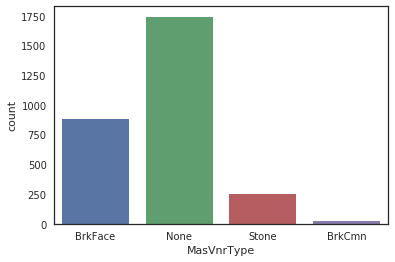

In [1949]:
sns.countplot(x='MasVnrType',data=dataset)

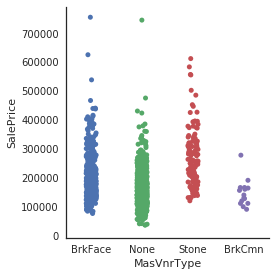

In [1950]:
sns.factorplot(x='MasVnrType',y='SalePrice',data=dataset,kind='strip',jitter=True)

In [1951]:
# tbd here make it simple
dataset.loc[dataset['MasVnrType'].isnull(),'MasVnrType'] = 'None'


#### MiscFeature

In [1952]:
MiscFeature_notnull_set = dataset.loc[dataset['MiscFeature'].isnull()==False]

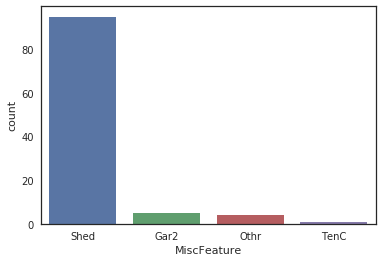

In [1953]:
sns.countplot('MiscFeature',data=MiscFeature_notnull_set)

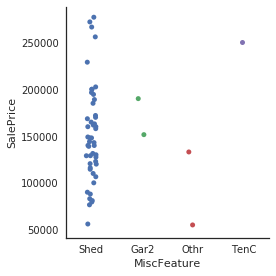

In [1954]:
sns.factorplot(x='MiscFeature',y='SalePrice',data=MiscFeature_notnull_set,kind='strip',jitter=True)

In [1955]:
dataset.loc[ dataset['MiscFeature'].isnull(),'MiscFeature']='Shed' 

#### PoolQC

In [1956]:
PoolQC_notnull_set =  dataset.loc[dataset['PoolQC'].isnull() == False]
len(PoolQC_notnull_set)

10

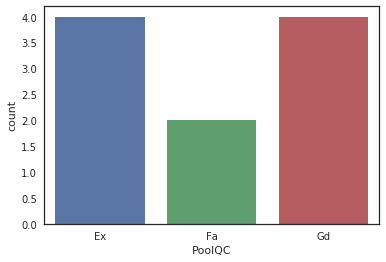

In [1957]:
sns.countplot(x='PoolQC',data=PoolQC_notnull_set)

In [1958]:
if 'PoolQC' in dataset.columns:
     dataset.drop( labels='PoolQC',axis=1,inplace=True);

#### TotalBsmtSF

In [1959]:
dataset.loc[dataset['TotalBsmtSF'].isnull(),'TotalBsmtSF'] = dataset['TotalBsmtSF'].median()

#### Utilities


In [1960]:
dataset.loc[dataset['Utilities'].isnull(),'Utilities'] = 'AllPub'

#### SaleType


In [1961]:
dataset.loc[dataset['SaleType'].isnull(),'SaleType'] = 'Other'

#### LotFrontage

In [1962]:
dataset.loc[dataset['LotFrontage'].isnull(),'LotFrontage'] = dataset['LotFrontage'].median()

#### GarageArea

In [1963]:
dataset.loc[dataset['GarageArea'].isnull(),'GarageArea'] = dataset['GarageArea'].median()

#### GarageCars

In [1964]:
dataset.loc[dataset['GarageCars'].isnull(),'GarageCars'] = dataset['GarageCars'].median()

#### Functional

In [1965]:
dataset.loc[dataset['Functional'].isnull(),'Functional']='Typ'

#### KitchenQual

In [1966]:
dataset.loc[dataset['KitchenQual'].isnull(),'KitchenQual']='TA'

#### GarageCond


In [1967]:
Garage_fl =  ['GarageCond','GarageQual','GarageArea','GarageCars','GarageFinish','GarageType']
Garage_cat_fl = ['GarageCond','GarageQual','GarageFinish','GarageType']

In [1968]:
null_cond = (dataset['GarageCond'].isnull() ) |\
                                               (dataset['GarageQual'].isnull() ) |\
                                               (dataset['GarageFinish'].isnull() ) |\
                                                (dataset['GarageType'].isnull() )
Garage_null_set=dataset.loc[null_cond]

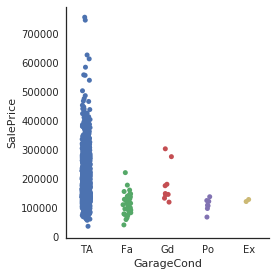

In [1969]:
Garage_notnull_set=dataset.loc[ (dataset['GarageCond'].isnull()==False) | (dataset['MiscFeature'] == 'Gar2' )]
sns.factorplot(x='GarageCond',y='SalePrice',data=Garage_notnull_set,kind='strip',jitter=True)

In [1970]:
Garage_notnull_set[Garage_cat_fl].describe()

,GarageCond,GarageQual,GarageFinish,GarageType
count,2760,2760,2760,2760
unique,5,5,3,6
top,TA,TA,Unf,Attchd
freq,2654,2604,1230,1723


Find those not NaN or 0:

In [1971]:
not_null_cond = (Garage_null_set['GarageCond'].isnull() == False) |\
                                   (Garage_null_set['GarageQual'].isnull() == False ) |\
                                  (Garage_null_set['GarageArea'] != 0 ) |\
                                  (Garage_null_set['GarageCars'] != 0 ) |\
                                  (Garage_null_set['GarageFinish'].isnull() == False ) |\
                                  (Garage_null_set['GarageType'].isnull() == False )
Garage_null_set.loc[ not_null_cond,Garage_fl ]

,GarageCond,GarageQual,GarageArea,GarageCars,GarageFinish,GarageType
2126,NaN,NaN,360.0,1.0,NaN,Detchd
2576,NaN,NaN,480.0,2.0,NaN,Detchd


In [1972]:
for x in Garage_cat_fl :
    dataset.loc[null_cond,x] =Garage_notnull_set[Garage_cat_fl].describe().loc['top'][x] 

#### GarageQual

#### GarageType

##### Garage year built

In [1973]:
dataset.loc[dataset['GarageYrBlt'].isnull(),'GarageYrBlt'] = dataset.loc[dataset['GarageYrBlt'].isnull(),'YearBuilt'] 

In [1974]:
if 'SalePrice' in dataset:
    dataset.drop(labels='SalePrice',axis=1,inplace=True)

In [1975]:
sum (dataset.isnull().sum() )

0

### Feature Engineering

In [1976]:
dataset.dtypes

1stFlrSF            int64
2ndFlrSF            int64
3SsnPorch           int64
Alley              object
BedroomAbvGr        int64
BldgType           object
BsmtCond           object
BsmtExposure       object
BsmtFinSF1        float64
BsmtFinSF2        float64
BsmtFinType1       object
BsmtFinType2       object
BsmtFullBath      float64
BsmtHalfBath      float64
BsmtQual           object
BsmtUnfSF         float64
CentralAir         object
Condition1         object
Condition2         object
Electrical         object
EnclosedPorch       int64
ExterCond          object
ExterQual          object
Exterior1st        object
Exterior2nd        object
Fence            category
FireplaceQu        object
Fireplaces          int64
Foundation         object
FullBath            int64
                   ...   
LotFrontage       float64
LotShape           object
LowQualFinSF        int64
MSSubClass          int64
MSZoning           object
MasVnrArea        float64
MasVnrType         object
MiscFeature 

In [1977]:
dataset.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'RoofMatl

Try to  distinguish numerical and categorial features

#### year

In [1978]:
year_fl = ['YearBuilt','YearRemodAdd','YrSold','GarageYrBlt']

In [1979]:
dataset.loc[ (dataset['YearBuilt'] >dataset['YearRemodAdd'])  | (dataset['YearRemodAdd'] >dataset['YrSold']) ,year_fl]

,YearBuilt,YearRemodAdd,YrSold,GarageYrBlt
523,2007,2008,2007,2007.0
1876,2002,2001,2009,2002.0
2295,2007,2008,2007,2007.0
2549,2008,2009,2007,2008.0


Garage first! it's strange

In [1980]:
dataset['YearBuiltTillNow'] = 2018-dataset['YearBuilt']
dataset['YearRemodTillNow'] = 2018-dataset['YearRemodAdd']
dataset['YearSoldTillNow'] = 2018-dataset['YrSold']
dataset['YearGaBuiltNow'] = 2018-dataset['GarageYrBlt']
dataset['RemodAfterBuilt'] = dataset['YearBuiltTillNow']  -  dataset['YearRemodTillNow'] 
dataset['SoldAfterBuilt'] = dataset['YearBuiltTillNow']  -  dataset['YearSoldTillNow'] 

dataset.loc[dataset['YearGaBuiltNow'] < 0,'YearGaBuiltNow'] = dataset.loc[dataset['YearGaBuiltNow'] < 0,'YearBuilt'] 

for x in year_fl:
    if x in dataset:
        dataset.drop(labels=x,axis=1,inplace= True)

In [1981]:
dataset.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64'), category,
       dtype('bool')], dtype=object)

In [1982]:
cat_dataset = dataset.select_dtypes(include=['object','bool'])

In [1983]:
for col in cat_dataset:
    cat_dataset[col] = cat_dataset[col].astype('category')


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1984]:
cat_dataset.dtypes.unique()

array([category], dtype=object)

In [1985]:
num_dataset = dataset.select_dtypes(exclude=['object','category']).astype('float64')

Check no data smaller than 0 ,thus can apply log skew method

In [1986]:
pos = np.where( num_dataset < 0 )
pos[0]

array([1876, 2549])

In [1987]:
num_dataset.loc[ num_dataset['RemodAfterBuilt'] < 0,'RemodAfterBuilt'] = 0
num_dataset.loc[ num_dataset['SoldAfterBuilt'] < 0,'SoldAfterBuilt'] = 0

In [1988]:
pos = np.where( num_dataset < 0 )
pos[0]

array([], dtype=int64)

#### unskew data

In [1989]:
from scipy.stats import skew
skew_feats = num_dataset.apply(skew).sort_values(ascending=False)
skew_feats.head(10)

YearGaBuiltNow    28.399911
MiscVal           21.947195
PoolArea          16.898328
LotArea           12.822431
LowQualFinSF      12.088761
3SsnPorch         11.376065
FullnullBsmt       5.910684
KitchenAbvGr       4.302254
BsmtFinSF2         4.146143
EnclosedPorch      4.003891
dtype: float64

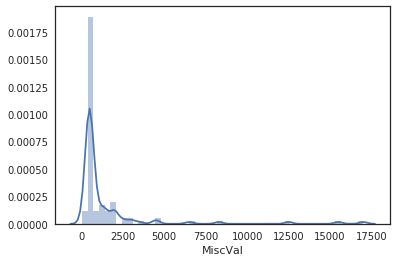

In [1990]:
sns.distplot(num_dataset[num_dataset['MiscVal'] != 0]['MiscVal'])

In [1991]:
skew_feats = skew_feats[abs(skew_feats) > 10]

print(skew_feats)

for feat in skew_feats.index:
    num_dataset[feat] = np.log1p(num_dataset[feat])

YearGaBuiltNow    28.399911
MiscVal           21.947195
PoolArea          16.898328
LotArea           12.822431
LowQualFinSF      12.088761
3SsnPorch         11.376065
dtype: float64


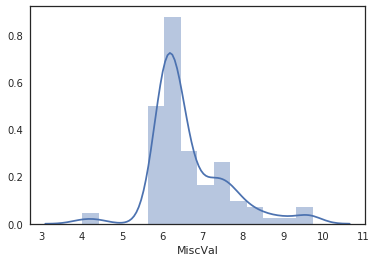

In [1992]:
sns.distplot(num_dataset[num_dataset['MiscVal'] != 0]['MiscVal'])

#### featured

In [1993]:
cat_dataset = pd.get_dummies(cat_dataset, columns = cat_dataset.columns);

min-max  or normalazation

In [1994]:
np.where(num_dataset < 0)

(array([], dtype=int64), array([], dtype=int64))

In [1995]:
for x in num_dataset:
     num_dataset[x] = (num_dataset[x] - num_dataset[x].mean()) / (num_dataset[x].std())
#         num_dataset[x] = (num_dataset[x] - num_dataset[x].mean()) / (num_dataset[x].max() - num_dataset[x].min())

normalization

In [1996]:
sum (np.isnan(num_dataset).any())

0

In [1997]:
np.where(np.isnan(num_dataset))

(array([], dtype=int64), array([], dtype=int64))

In [1998]:
num_dataset = num_dataset.fillna(num_dataset.median())

In [1999]:
sum (np.isnan(num_dataset).any())

0

In [2000]:
dataset = pd.concat([cat_dataset,num_dataset],axis=1)

X = dataset[:train_len]
X_test   = dataset[train_len:]
sum(X.isnull().sum())

# y = train.pop('SalePrice')

0

In [2001]:
sum(X_test.isnull().sum() )
X.shape

(1460, 288)

In [2002]:
X_test.shape

(1459, 288)

### Build Models

In [2003]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso,LassoCV
from sklearn.linear_model import Ridge,RidgeCV
# K折线 学习曲线 

from sklearn.model_selection import GridSearchCV, \
                                                            cross_val_score, \
                                                            StratifiedKFold, \
                                                            learning_curve,\
                                                            KFold,\
                                                            cross_val_predict;
from sklearn.model_selection import train_test_split;
sns.set(style='white', context='notebook', palette='deep');
from sklearn.metrics import mean_squared_error,mean_squared_log_error,median_absolute_error
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)


In [2004]:
def train_model(estimator=None, X_train=None,y_train=None,X_cv=None,y_cv=None):
    m = estimator
    m.fit(X_train,y_train)
    pred=estimator.predict(X_cv)
#     print(np.where(np.isnan(pred)))
    score = np.sqrt (mean_squared_log_error(y_cv,pred))
    
    #What's inside mean_squared_log_error...
#     sq_diff = np.square(np.log(y_cv)-np.log(pred))
#     score= np.sqrt(np.sum(sq_diff)/y_cv.shape[0])
#     print('s2 ',score)
    return score,m

def train_model_1(estimator=None, X_train=None,y_train=None,X_cv=None,y_cv=None):
    m = estimator
    m.fit(X_train,np.log1p(y_train))
    pred=estimator.predict(X_cv)
#     print(np.where(np.isnan(pred)))
    score = np.sqrt (mean_squared_error(np.log1p(y_cv),pred))
    
    #What's inside mean_squared_log_error...
#     sq_diff = np.square(np.log(y_cv)-np.log(pred))
#     score= np.sqrt(np.sum(sq_diff)/y_cv.shape[0])
#     print('s2 ',score)
    return score,m
    

In [2005]:
def gen_submission(csvname=None,X_test=None,models=None):
    pred=np.expm1(models.predict(X_test))
    result  = pd.concat([ids,pd.Series(pred).astype('float64')],axis=1);
    result.columns = ['Id','SalePrice']
    result.to_csv(csvname+r'.csv',index=False)
    pass

In [2006]:
X.dtypes.unique()

array([dtype('uint8'), dtype('float64')], dtype=object)

In [2007]:
X = X.astype('float64')

In [2008]:
X.shape

(1460, 288)

Check on nan or inf values

In [2009]:
sum(np.isnan(X).all())

0

In [2010]:
sum (np.isinf(X).any() )

0

#### LR models

##### select models

In [2011]:
scores_cv = [] 
scores_test=[]

models = []
LR_ridge = Ridge(alpha=20)
LR_lasso = Lasso(alpha=0.0005)
models.append( ['ridge',LR_ridge ])
models.append(['lasso',LR_lasso])

times = 50;

score_mat = np.empty( (times,len(models),2))

print('test vs cv score:')


for i in range(times):
#     kf = StratifiedKFold(n_splits=10,shuffle=True)
    
    X_train, X_vld, y_train,y_vld = train_test_split(X,y,train_size=0.8,shuffle=True)
    j=0;
    for n,m in models:
        s,fin = train_model_1(m,X,y,X,y)
#         print('model ',n, ' test score: ',s)
        score_mat[i,j,0] = s
        s,fin = train_model_1(m,X_train,y_train,X_vld,y_vld)
#          print('model ',n, ' cv score: ',s)
        score_mat[i,j,1] = s
        j = j+1

# print(score_mat)
print('For models', list(map(lambda x: x[0] ,models)))
print('Ave test score: ' ,np.mean(score_mat,axis=0)[:,0])
print('Ave cv score: ' ,np.mean(score_mat,axis=0)[:,1])

test vs cv score:


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


For models ['ridge', 'lasso']
Ave test score:  [0.11415685 0.10674245]
Ave cv score:  [0.13699223 0.13191911]


cv score is larger than test score . so the model is over fit as though

##### Cross validation using kfolds

In [2012]:
scores = -1 * cross_val_score(LR,X,np.log1p(y),scoring='neg_mean_squared_error',cv=5)
np.sqrt(scores).mean()

0.39922568603836983

##### Grid search

In [2013]:
LR = Lasso()
kf = StratifiedKFold(n_splits=5,shuffle=True)
lasso_param_grid = {
                "alpha":[0.001,0.0005,0.0007] ,
                 "max_iter":[1000,800,500],
                 "tol":[0.005,0.01,0.02],
#                 "fit_intercept":[True,False],
}
#                   "tol":[0.005,0.01,0.02],
#                   "fit_intercept":[True,False]}

rcv_param_grid = {}

gsLR = GridSearchCV(LR,param_grid = lasso_param_grid, cv=10,n_jobs= 1, verbose = 1)

gsLR.scoring = 'neg_mean_squared_error'


gsLR.fit(X,np.log1p(y))

bestLR= gsLR.best_estimator_
                 
print(bestLR)
# Best score
print(np.sqrt(-gsLR.best_score_))

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Lasso(alpha=0.0007, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.005, warm_start=False)
0.13738235750912559


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    5.0s finished


#### Learning curves

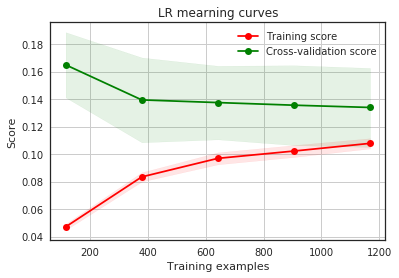

In [2014]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring='neg_mean_squared_error')
    train_scores = np.sqrt(-train_scores)
    test_scores = np.sqrt(-test_scores)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(bestLR,"LR mearning curves",X,np.log1p(y),cv=5)

##### Submission

In [ ]:
gen_submission("LassoCV_submission",X_test,bestLR)

#### LRCV model

##### LassoCV

In [ ]:
LR_lasso_cv = LassoCV();
LR_lasso_cv.fit(X,y)
g = plot_learning_curve(LR_lasso_cv,"Lasso cv mearning curves",X,np.log1p(y),cv=10)

##### single parameter regulation , not using GridSearch

In [ ]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, np.log1p(y), scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [ ]:
# alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
#confirm 10

alphas = [5,6,7,8,9,10,20,30,50]
#confirm 20

cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]


cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
print(cv_ridge)
plt.xlabel("alpha")
plt.ylabel("rmse")

In [ ]:
alphas = [0.00001,0.00005,0.0001,0.0005,0.001,]
#confirm 0.0005

#confirm 20
alphas = [0.0001,0.0003,0.0005,0.0007,0.001]

cv_ridge = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]


cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
print(cv_ridge)
plt.xlabel("alpha")
plt.ylabel("rmse")

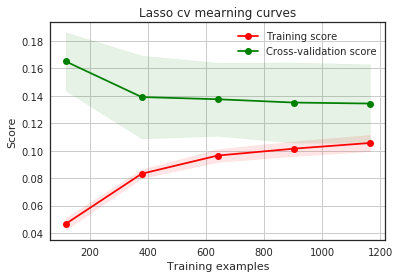

In [1881]:
LR_lasso_cv = LassoCV(alphas=[0.0004,0.0005,0.0006,0.0007]);
LR_lasso_cv.fit(X,np.log1p(y))
g = plot_learning_curve(LR_lasso_cv,"Lasso cv mearning curves",X,np.log1p(y),cv=5)

In [1435]:
# got a 0.12 here
gen_submission('Lasso_cv',X_test,LR_lasso_cv)